In [1]:
import matplotlib.pyplot as plt, numpy as np, pickle, os, random
import game as g, neuralnetworks as nn

In [2]:
results_path, experiment_no = os.getcwd()+'/Results', 1

In [3]:
with (open(os.path.join(results_path, f'{experiment_no}. Metadata.meta'), 'rb')) as open_file:
    while True:
        try:
            meta = pickle.load(open_file)
            print(f'Runs: {meta["runs"]}\nBin size: {meta["bin_size"]}')
        except EOFError:
            break
open_file.close()

Runs: 5
Bin size: 10


In [4]:
with (open(os.path.join(results_path, f'{experiment_no}. Parameters.pth'), 'rb')) as open_file:
    while True:
        try:
            parameters = pickle.load(open_file)
            print(f'Epochs: {parameters["epochs"]}\nReps: {parameters["games_per_epoch"]}\nNetwork: {parameters["network"]}\nUpdates per Epoch: {parameters["updates_per_epoch"]}\nLearning Rate: {parameters["learning_rate"]}\nMin Epsilon: {parameters["min_epsilon"]}\nEpsilon Decay Factor: {parameters["epsilon_decay_factor"]}\nSGD: {parameters["use_SGD"]}')
        except EOFError:
            break
open_file.close()

Epochs: 1000
Reps: 1000
Network: [256, 256, 256]
Updates per Epoch: 25
Learning Rate: 1e-05
Min Epsilon: 0.01
Epsilon Decay Factor: 0.995
SGD: True


In [7]:
Qnets, outputs = [], []
for i in range(meta['runs']):
    with (open(os.path.join(results_path, f'{experiment_no}. Qnet - Run {i+1}.pt'), 'rb')) as open_file:
        while True:
            try:
                Qnet = pickle.load(open_file)
                Qnets.append(Qnet)
            except EOFError:
                break
    open_file.close()
    with (open(os.path.join(results_path, f'{experiment_no}. Outputs - Run {i+1}.pth'), 'rb')) as open_file:
        while True:
            try:
                output = pickle.load(open_file)
                outputs.append(output)
            except EOFError:
                break
    open_file.close()

In [8]:
Qnets[0].training_time

93818.67

In [13]:
Qnets[0]

NN(
  (model): Sequential(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [16]:
import torch
torch.cuda.current_device()

0

In [17]:
Qnets[0].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')).double()

NN(
  (model): Sequential(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [23]:
Qnets[0].to('cpu').double()
next(Qnets[0].parameters()).is_cuda

False

In [9]:
def plot_results(win_rate, bin_size):
    plt.figure(figsize=(5, 4))
    plt.gca().set(title=f'Highest win rate during training: {np.max(win_rate)}\nWin rate at training end: {win_rate[-1]}', xlabel='Epoch', ylabel='Averaged Win %', ylim=(50, 100)) # Set standard range for y
    plt.plot(range(bin_size, bin_size+len(win_rate)), win_rate)
    return

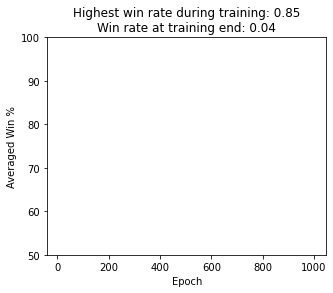

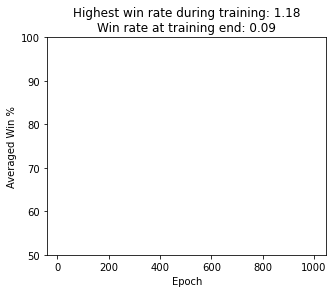

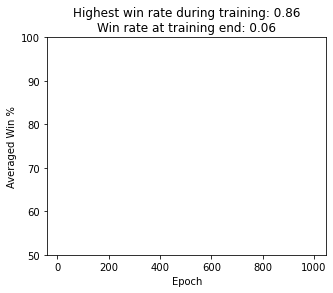

In [10]:
for output in outputs:
    plot_results(output['win_rate'], meta['bin_size'])

In [11]:
def plot_wins(win_rates, bin_size):
    plt.figure(figsize=(5, 4))
    plt.gca().set(title='Wins', xlabel='Epoch', ylabel='Win % Range', ylim=(50, 100)) # Set standard range for y
    plt.plot(range(bin_size, bin_size+win_rates.shape[1]), np.mean(win_rates, axis=0)) # Plotting win rate averaged over 5 runs
    plt.fill_between(range(bin_size, bin_size+win_rates.shape[1]), np.min(win_rates, axis=0), np.max(win_rates, axis=0), color='orange', alpha=0.3) # Plotting minimum and maximum values for individual runs
    plt.savefig('testing.png')
    return

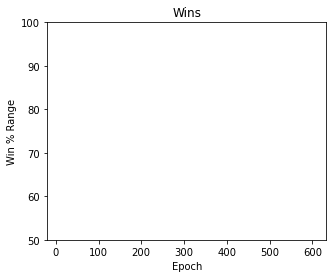

In [12]:
plot_wins(np.array([output['win_rate'] for output in outputs]).reshape(meta['runs'], -1), meta['bin_size'])

In [10]:
def move_to_onehot(move):
    onehot_move = [0]*24
    onehot_move[move] = 1
    return onehot_move

In [11]:
def epsilon_greedy(state, valid_moves_F, Qnet, epsilon, turn):
    moves = g.valid_moves(state)
    if np.random.uniform() < epsilon: # Random move
        move = moves[random.sample(range(len(moves)), 1)[0]] # Random opponent
    else: # Greedy move
        Qs = [Qnet.use_pytorch(np.array(state + move_to_onehot(m)))[0] if Qnet.processed is True else 0 for m in moves] # Q values for deciding greedy move
        move = moves[np.argmax(Qs)] if turn else moves[random.sample(range(len(moves)), 1)[0]] # Random opponent
    Q = Qnet.use_pytorch(np.array(state + move_to_onehot(move)))[0] if Qnet.processed is True else 0
    return move, Q

In [12]:
#Qnets[0].state_dict()

In [13]:
#print(Qnets[0].state_dict()['model.0.weight'].detach().cpu().numpy()[0])
#print(Qnets[0].state_dict()['model.0.weight'].detach().cpu().numpy()[0].shape)

In [14]:
state, turn = [0]*24, True
g.print_game(state)

•   •   •   •

•   •   •   •

•   •   •   •

•   •   •   •


In [15]:
move, _ = epsilon_greedy(state, g.valid_moves, Qnets[1], 0, turn)
g.print_game(g.make_move(state, move))

•   •   •   •
    |
•   •   •   •

•   •   •   •

•   •   •   •


In [16]:
state, turn = [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], True
g.print_game(state)

•---•---•---•
|           |
•---•---•   •
            |
•   •   •---•

•   •   •   •


In [17]:
move, _ = epsilon_greedy(state, g.valid_moves, Qnets[1], 0, turn)
state = g.make_move(state, move)
g.print_game(g.make_move(state, move))

•---•---•---•
|   |       |
•---•---•   •
            |
•   •   •---•

•   •   •   •


In [18]:
move, _ = epsilon_greedy(state, g.valid_moves, Qnets[1], 0, turn)
g.print_game(g.make_move(state, move))

•---•---•---•
|   |       |
•---•---•   •
|           |
•   •   •---•

•   •   •   •


In [19]:
state, turn = [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0], True
g.print_game(state)

•---•   •   •
|   |   |   |
•   •---•   •
|   |       |
•   •   •---•
|   |
•   •---•---•


In [20]:
move, _ = epsilon_greedy(state, g.valid_moves, Qnets[1], 0, turn)

In [21]:
g.print_game(g.make_move(state, move))

•---•   •   •
|   |   |   |
•   •---•   •
|   |       |
•   •   •---•
|   |   |
•   •---•---•


In [ ]:
num_tests, runs, num_games = 3, 5, 10 # Meta parameters
testing = []
for i in range(num_tests):
    print(f'Testing => Test {i+1}')
    percentages = []
    for j in range(runs):
        outcomes = []
        for k in range(num_games):
            state, boxes, score, done = [0]*24, [0]*9, [0]*2, False
            turn = True
            move, _ = epsilon_greedy(state, g.valid_moves, Qnets[1], 0, turn)
            while not done:
                state_next = g.make_move(state, move)
                created, boxes = g.box_created(state_next, boxes)
                if created > 0:
                    if turn:
                        score[0] += created
                    else:
                        score[1] += created
                else:
                    turn = not turn
                if 0 not in state_next:
                    r = 1 if score[0] > score[1] else -1
                    outcome, done = r, True
                    move_next, Qnext = -1, 0
                else:
                    move_next, Qnext = epsilon_greedy(state_next, g.valid_moves, Qnets[1], 0, turn)
                state, move = state_next, move_next
            outcomes.append(outcome)
        percentages.append(sum(outcomes[k] == 1 for k in range(len(outcomes)))/num_games*100)
    testing.append(sum(percentages)/runs)
    print(f'Finished test {i+1}; Percent: {testing[-1]}')

In [22]:
results_path = os.getcwd()+'/Results-v2'

In [23]:
with (open(os.path.join(results_path, 'Metadata_best.meta'), 'rb')) as meta_file, (open(os.path.join(results_path, 'Parameters_best.pth'), 'rb')) as params_file, (open(os.path.join(results_path, 'Qnet_best.pt'), 'rb')) as Qnet_file, (open(os.path.join(results_path, 'Outputs_best.pth'), 'rb')) as output_file: # Read from stored files
    while True:
        try:
            meta_best, parameters_best, Qnet_best, output_best = pickle.load(meta_file), pickle.load(params_file), pickle.load(Qnet_file), pickle.load(output_file)
        except EOFError:
            break
meta_file.close(), params_file.close(), Qnet_file.close(), output_file.close()

(None, None, None, None)

In [24]:
def epsilon_greedy_2(state, valid_moves_F, Qnet, Qnet_2, epsilon, turn):
    moves = valid_moves_F(state)
    Qs = [Qnet.use_pytorch(np.array(state + move_to_onehot(m)))[0] if Qnet.processed is True else 0 for m in moves] # Q values for Qnet
    Q_2s = [Qnet_2.use_pytorch(np.array(state + move_to_onehot(m)))[0] for m in moves] # Q values for Qnet_2
    if np.random.uniform() < epsilon: # Random move
        move = moves[random.sample(range(len(moves)), 1)[0]] if not turn else moves[np.argmax(Q_2s)] # Intelligent opponent
    else: # Greedy move
        move = moves[np.argmin(Qs)] if not turn else moves[np.argmax(Q_2s)] # Intelligent opponent
    return move, Qnet.use_pytorch(np.array(state + move_to_onehot(move)))[0] if not turn else Qnet_2.use_pytorch(np.array(state + move_to_onehot(move)))[0]

In [25]:
num_tests, runs, num_games = 3, 5, 10 # Meta parameters
testing = []
for i in range(num_tests):
    print(f'Testing => Test {i+1}')
    percentages = []
    for j in range(runs):
        outcomes = []
        for k in range(num_games):
            state, boxes, score, done = [0]*24, [0]*9, [0]*2, False
            turn = True
            move, _ = epsilon_greedy_2(state, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
            while not done:
                state_next = g.make_move(state, move)
                created, boxes = g.box_created(state_next, boxes)
                if created > 0:
                    if turn:
                        score[0] += created
                    else:
                        score[1] += created
                else:
                    turn = not turn
                if 0 not in state_next:
                    r = 1 if score[0] > score[1] else -1
                    outcome, done = r, True
                    move_next, Qnext = -1, 0
                else:
                    move_next, Qnext = epsilon_greedy_2(state_next, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
                state, move = state_next, move_next
            outcomes.append(outcome)
        #print(outcomes)
        percentages.append(sum(outcomes[k] == -1 for k in range(len(outcomes)))/num_games*100)
    testing.append(sum(percentages)/runs)
    print(f'Finished test {i+1}; Percent: {testing[-1]}')

Testing => Test 1
Finished test 1; Percent: 100.0
Testing => Test 2
Finished test 2; Percent: 100.0
Testing => Test 3
Finished test 3; Percent: 100.0


In [ ]:
def epsilon_greedy_3(state, valid_moves_F, Qnet, epsilon, turn):
    moves = valid_moves_F(state)
    Qs = [Qnet.use_pytorch(np.array(state + move_to_onehot(m)))[0] if Qnet.processed is True else 0 for m in moves] # Q values for Qnet
    if np.random.uniform() < epsilon: # Random move
        move = moves[random.sample(range(len(moves)), 1)[0]] # Random opponent
    else: # Greedy move
        move = moves[np.argmin(Qs)] if not turn else moves[random.sample(range(len(moves)), 1)[0]] # Random opponent
    return move, Qnet.use_pytorch(np.array(state + move_to_onehot(move)))[0]

In [26]:
num_tests, runs, num_games = 3, 5, 10 # Meta parameters
testing = []
for i in range(num_tests):
    print(f'Testing => Test {i+1}')
    percentages = []
    for j in range(runs):
        outcomes = []
        for k in range(num_games):
            state, boxes, score, done = [0]*24, [0]*9, [0]*2, False
            turn = True
            move, _ = epsilon_greedy_3(state, g.valid_moves, Qnet_best, 0, turn)
            while not done:
                state_next = g.make_move(state, move)
                created, boxes = g.box_created(state_next, boxes)
                if created > 0:
                    if turn:
                        score[0] += created
                    else:
                        score[1] += created
                else:
                    turn = not turn
                if 0 not in state_next:
                    r = 1 if score[0] > score[1] else -1
                    outcome, done = r, True
                    move_next, Qnext = -1, 0
                else:
                    move_next, Qnext = epsilon_greedy_3(state_next, g.valid_moves, Qnet_best, 0, turn)
                state, move = state_next, move_next
            outcomes.append(outcome)
        #print(outcomes)
        percentages.append(sum(outcomes[k] == -1 for k in range(len(outcomes)))/num_games*100)
    testing.append(sum(percentages)/runs)
    print(f'Finished test {i+1}; Percent: {testing[-1]}')

Testing => Test 1


NameError: name 'epsilon_greedy_3' is not defined

In [ ]:
state, turn = [0]*24, False
g.print_game(state)

In [ ]:
move, _ = epsilon_greedy_2(state, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
g.print_game(g.make_move(state, move))

In [ ]:
state, turn = [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], False
g.print_game(state)

In [ ]:
move, _ = epsilon_greedy_2(state, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
g.print_game(g.make_move(state, move))
state = g.make_move(state, move)

In [ ]:
move, _ = epsilon_greedy_2(state, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
g.print_game(g.make_move(state, move))

In [ ]:
state, turn = [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0], False
g.print_game(state)

In [ ]:
move, _ = epsilon_greedy_2(state, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
g.print_game(g.make_move(state, move))
state = g.make_move(state, move)

In [ ]:
move, _ = epsilon_greedy_2(state, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
g.print_game(g.make_move(state, move))
state = g.make_move(state, move)

In [ ]:
move, _ = epsilon_greedy_2(state, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
g.print_game(g.make_move(state, move))
state = g.make_move(state, move)

In [ ]:
move, _ = epsilon_greedy_2(state, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
g.print_game(g.make_move(state, move))
state = g.make_move(state, move)

In [38]:
game = []
state, boxes, score, done = [0]*24, [0]*9, [0]*2, False
turn = True
move, _ = epsilon_greedy_2(state, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
while not done:
    state_next = g.make_move(state, move)
    if turn:
        print('Opponent move')
    else:
        print('Agent move')
    g.print_game(state_next, move)
    print()
    created, boxes = g.box_created(state_next, boxes)
    if created > 0:
        if turn:
            score[0] += created
        else:
            score[1] += created
    else:
        turn = not turn
    if 0 not in state_next:
        r = 1 if score[0] > score[1] else -1
        outcome, done = r, True
        move_next, Qnext = -1, 0
    else:
        move_next, Qnext = epsilon_greedy_2(state_next, g.valid_moves, Qnet_best, Qnets[1], 0, turn)
    state, move = state_next, move_next
print(f'Score:\nOpponent: {score[0]}\tAgent: {score[1]}')

Opponent move
•   •   •   •
    |
•   •   •   •

•   •   •   •

•   •   •   •

Agent move
•   •   •   •
    |
•   •   •   •

•   •   •   •
            |
•   •   •   •

Opponent move
•   •   •   •
    |
•   •   •   •
|
•   •   •   •
            |
•   •   •   •

Agent move
•   •   •   •
|   |
•   •   •   •
|
•   •   •   •
            |
•   •   •   •

Opponent move
•   •   •   •
|   |   |
•   •   •   •
|
•   •   •   •
            |
•   •   •   •

Agent move
•   •   •   •
|   |   |   |
•   •   •   •
|
•   •   •   •
            |
•   •   •   •

Opponent move
•   •   •   •
|   |   |   |
•   •   •   •
|
•   •   •   •
        |   |
•   •   •   •

Agent move
•   •   •   •
|   |   |   |
•   •   •---•
|
•   •   •   •
        |   |
•   •   •   •

Opponent move
•   •   •   •
|   |   |   |
•   •   •---•
|
•   •   •   •
        |   |
•---•   •   •

Agent move
•   •   •---•
|   |   |   |
•   •   •---•
|
•   •   •   •
        |   |
•---•   •   •

Agent move
•   •   •---•
|   |   |   |
•   •   •---•
|
•

In [99]:
state = [0]*24
#state[1], state[13], state[14] = 1, 1, 1
#state[5], state[18], state[8] = 1, 1, 1
state[16], state[17] = 1, 1
state[21], state[22] = 1, 1
state[1], state[13] = 1, 1
state[5], state[18] = 1, 1
state[12], state[20], state[2], state[23] = 0, 1, 1, 1

In [100]:
moves = g.valid_moves(state)
moves

[0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 19]

In [101]:
g.print_game(state)

•   •---•---•
    |
•   •   •---•
|   |   |
•   •   •   •
|   |   |   |
•   •   •   •


In [110]:
def get_move_heuristic(state, moves):
    boxes_edges_index = g.boxes_edges_index_generate() # Generate index of all edges for all boxes
    boxes_edges, boxes_3s, boxes_2s = [], [], []
    for box_edges in boxes_edges_index: # Generate binary 0/1 of whether each edge in index exists in state
        boxes_edges.append([state[i] for i in box_edges])
    for i in range(len(boxes_edges)):
        if sum(boxes_edges[i]) == 3: # Find boxes with 3 edges completed
            boxes_3s.append(i)
        if sum(boxes_edges[i]) == 2: # Find boxes with 2 edges completed
            boxes_2s.append(i)
    moves_3s = [boxes_edges_index[box_3s][boxes_edges[box_3s].index(0)] for box_3s in boxes_3s] # List all available moves in boxes with 3 edges complete
    moves_2s = list(set([i for x in [[boxes_edges_index[i][j] for j in list(np.where(np.array(boxes_edges[i]) == 0)[0])] for i in boxes_2s] for i in x])) # List all available moves in boxes with 2 edges complete
    if len(boxes_3s) > 0: # If there are boxes with 3 edges complete, choose a move from those
        move = random.choice(moves_3s)
    elif len(boxes_2s) > 0: # If there are boxes with 2 edges complete, try not to choose a move from those
        avail_moves = [m for m in moves if m not in moves_2s] # Check if there are available moves to not make a 3rd edge to a 2-edge box
        move = random.choice(avail_moves) if len(avail_moves) > 0 else random.choice(moves)
    else: # Else choose a move at random
        move = random.choice(moves)
    return move

In [129]:
get_move_heuristic(state, moves)

0